## Feature Selection - Handling Multicolleniarity using Pearson Correlation 

### How to detect multicolleniarity ? 

1. Using Pearson Correlation Coefficient
2. Using Variance Inflation Factor

**Why we use VIF and not Correlation Matrix to detect Multicollinearity?**<br>
Correlation Matrix shows the correlation between any two variables (Xi and Xj). However, there is multicollinearity in data if one independent variable X1 can be predicted from one or more other independent variables (X2, X3, …. Xn) (we may have many highly correlated independent features with each other). This essence of one or more is captured in VIF. As such, we use VIF to detect multicollinearity in data rather than Correlation.

In [50]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Loading the dataset
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
245,0.19133,22.0,5.86,0.0,0.431,5.605,70.2,7.9549,7.0,330.0,19.1,389.13,18.46
59,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22
276,0.10469,40.0,6.41,1.0,0.447,7.267,49.0,4.7872,4.0,254.0,17.6,389.25,6.05
395,8.71675,0.0,18.10,0.0,0.693,6.471,98.8,1.7257,24.0,666.0,20.2,391.98,17.12
416,10.83420,0.0,18.10,0.0,0.679,6.782,90.8,1.8195,24.0,666.0,20.2,21.57,25.79


In [51]:
# Check model performance without hanlding multicolleniarity (without removing any high correlated independet feature)
lr = Pipeline([('scaler', StandardScaler()),
               ('estimator', LinearRegression())])

print(f"CV Score : {np.mean(cross_val_score(lr, X_train, y_train, scoring='r2'))}")

lr.fit(X_train, y_train)
print(f"Test Score : {r2_score(y_test, lr.predict(X_test))}")

CV Score : 0.7219153693705489
Test Score : 0.6354638433202132


### 1. Using Pearson Correlation Coefficient

**Since we have many features its little difficult to check from the correlation heatmap which features are correlated to each other. Thats way i will use a function which returns highly correlated features. We must give the threshold/correlation coefficient. Features that have a coef correlation higher than this threshold will be selected.**

**If we have only few features threshold must be higher, if we have many features we can set a lower threshold because we dont want to remove too many featuers when we dont have many features.**

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_heatmap(X_train):
    print('Entered function multicolleniarity of Preprocessor class.')
    try:
        plt.figure(figsize=(15, 10))
        cor = X_train.corr()
        sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
        plt.savefig('multicolleniarity_heatmap.jpg')

        print('Function multicolleniarity Completed Successfully. Exited this function.')
    except Exception as e:
        print('Error occured in function multicolleniarity of Preprocesor class. Error Message : ' + str(e))

Entered function multicolleniarity of Preprocessor class.
Function multicolleniarity Completed Successfully. Exited this function.


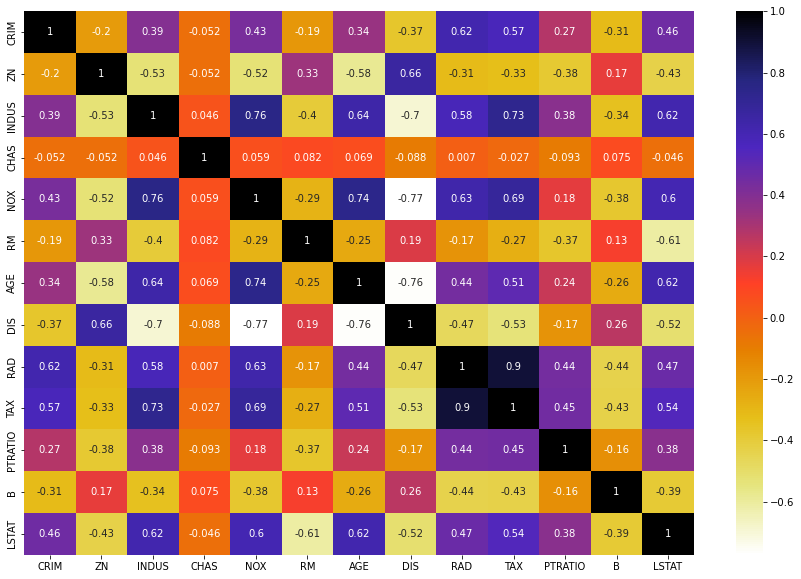

In [53]:
correlation_heatmap(X_train)

* Since we may have too many features its not a good idea to check the correlation heatmap. Lets instead write a function which finds out the features which are highly correlated.

In [54]:
def multicolleniarity(dataset, threshold):
    pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname1 = corr_matrix.columns[i]
                colname2 = corr_matrix.columns[j]
                pairs.add((colname1, colname2, corr_matrix.iloc[i,j]))
                
                
    return pairs

corr_features = multicolleniarity(X_train, 0.7)

for list_element in corr_features:
    print(f'Feature {list_element[0]} is correlated (corr={list_element[2]}) with {list_element[1]}')

print(corr_features)

Feature AGE is correlated (corr=0.7435241937850912) with NOX
Feature NOX is correlated (corr=0.7557077536504041) with INDUS
Feature TAX is correlated (corr=0.9023842776614198) with RAD
Feature DIS is correlated (corr=-0.7730832263411914) with NOX
Feature DIS is correlated (corr=-0.7604561822031224) with AGE
Feature TAX is correlated (corr=0.7292338235026389) with INDUS
{('AGE', 'NOX', 0.7435241937850912), ('NOX', 'INDUS', 0.7557077536504041), ('TAX', 'RAD', 0.9023842776614198), ('DIS', 'NOX', -0.7730832263411914), ('DIS', 'AGE', -0.7604561822031224), ('TAX', 'INDUS', 0.7292338235026389)}


### 2. Using Variance Inflation Factor

**How it works?**<br>
We consider each independent feature as target feature and fit a regression model using other independet features and check if this independent feature can be explained by other independent features which means it is highly correlated with them. That is indicated with a high value of r squared. Higher R Squared => higher variance inflaction vactor => high multicolleniarity of this feature. <br>
**Formula** : 1 / 1 - r_squared <br>

A) Using Built-in method variance_inflation_factor

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(dataset):
    vif_df = pd.DataFrame()
    vif_df['Features'] = dataset.columns
    vif_df['VIF_Value'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    
    return vif_df

In [56]:
vif(X_train)

,Features,VIF_Value
0,CRIM,2.077479
1,ZN,2.955173
2,INDUS,14.182319
3,CHAS,1.133392
4,NOX,78.333742
5,RM,80.799026
6,AGE,22.641405
7,DIS,15.311427
8,RAD,14.766841
9,TAX,58.327221


B) Variance Inflation Factor from Scratch

In [57]:
from scipy import stats
import statsmodels.api as sm

names = X_train.columns

for i in range(0, len(names)):
    y = X_train.loc[:, X_train.columns == names[i]]
    x = X_train.loc[:, X_train.columns != names[i]]
    model = sm.OLS(y, x)
    results = model.fit()
    rsq = results.rsquared
    vif_value = round(1 / (1 - rsq), 2)
    print(
        "R Square value of {} column is {} keeping all other columns as features".format(
            names[i], (round(rsq, 2))
        )
    )
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            names[i], vif_value)
        )

R Square value of CRIM column is 0.52 keeping all other columns as features
Variance Inflation Factor of CRIM column is 2.08 

R Square value of ZN column is 0.66 keeping all other columns as features
Variance Inflation Factor of ZN column is 2.96 

R Square value of INDUS column is 0.93 keeping all other columns as features
Variance Inflation Factor of INDUS column is 14.18 

R Square value of CHAS column is 0.12 keeping all other columns as features
Variance Inflation Factor of CHAS column is 1.13 

R Square value of NOX column is 0.99 keeping all other columns as features
Variance Inflation Factor of NOX column is 78.33 

R Square value of RM column is 0.99 keeping all other columns as features
Variance Inflation Factor of RM column is 80.8 

R Square value of AGE column is 0.96 keeping all other columns as features
Variance Inflation Factor of AGE column is 22.64 

R Square value of DIS column is 0.93 keeping all other columns as features
Variance Inflation Factor of DIS column is 

### Techniques to handle multicolleniarity 
1. Removing feature using Pearson Correlation Coefficient. 
2. Combine the correlated independet feature into 1 single feature using some logic.
3. Removing feature using Variance Inflation Factor.
3. Principal Component Analysis (PCA). 
4. Lasso Regression.

### 1. Removing one of highly correlated independent features.

* From many correlated independent features we should remove the features that is less correlated with target feature.

In [58]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [59]:
# automatization

def remove_features(X_train, y_train, X_test, features_correlated, target_feature):
    train_data = pd.concat([X_train, y_train], axis=1)
    corr_with_target = abs(train_data.corr()[target_feature][features_correlated])
    logical_vector = abs(train_data.corr()[target_feature]) == np.max(corr_with_target)
    feature_highest_correlation_with_target = train_data.corr()[target_feature].index[logical_vector][0]
    features_to_remove = [feature for feature in features_correlated if feature not in feature_highest_correlation_with_target]
     
    print(f'Feature with Highest Correlation with Target : {feature_highest_correlation_with_target}')
    print(f'Features to remove : {features_to_remove}')
    
    new_X_train = X_train.drop(columns=features_to_remove, axis=1)
    new_X_test = X_test.drop(columns=features_to_remove, axis=1)
    
    return new_X_train, new_X_test

In [60]:
X_train, X_test = remove_features(X_train, y_train, X_test, ['DIS', 'NOX', 'AGE'], 'MEDV')

Feature with Highest Correlation with Target : NOX
Features to remove : ['DIS', 'AGE']


In [61]:
X_train, X_test = remove_features(X_train, y_train, X_test, ['TAX', 'INDUS'], 'MEDV')

Feature with Highest Correlation with Target : INDUS
Features to remove : ['TAX']


In [62]:
X_train, X_test = remove_features(X_train, y_train, X_test, ['NOX', 'INDUS'], 'MEDV')

Feature with Highest Correlation with Target : INDUS
Features to remove : ['NOX']


4 features are removed.

In [63]:
# check that we have removed high correlated independent features
corr_features = multicolleniarity(X_train, 0.7)
print(corr_features)

set()


In [64]:
# check that we removed bath and bhk from training set 
'DIS' in X_train.columns or 'AGE' in X_train.columns 

False

In [65]:
# check that we removed bath and bhk from TEST set 
'DIS' in X_test.columns or 'AGE' in X_test.columns 

False

In [66]:
# check that training and test set have same columns and in same order
np.array_equal(X_train.columns, X_test.columns)

True

In [67]:
lr = Pipeline([('scaler', StandardScaler()),
               ('estimator', LinearRegression())])

print(f"CV Score : {np.mean(cross_val_score(lr, X_train, y_train, scoring='r2'))}")

lr.fit(X_train, y_train)
print(f"Test Score : {r2_score(y_test, lr.predict(X_test))}")

CV Score : 0.6841404302622356
Test Score : 0.5670676146793877


### 2. Combine the correlated independet feature into 1 single feature using some logic

In [68]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [69]:
corr_features = multicolleniarity(X_train, 0.7)
print(corr_features)

{('AGE', 'NOX', 0.7435241937850912), ('NOX', 'INDUS', 0.7557077536504041), ('TAX', 'RAD', 0.9023842776614198), ('DIS', 'NOX', -0.7730832263411914), ('DIS', 'AGE', -0.7604561822031224), ('TAX', 'INDUS', 0.7292338235026389)}


In [70]:
X_train['NOX_INDUS'] = X_train['NOX'] - X_train['INDUS']
X_train.drop(['NOX', 'INDUS'], axis=1, inplace=True)

X_test['NOX_INDUS'] = X_test['NOX'] - X_test['INDUS']
X_test.drop(['NOX', 'INDUS'], axis=1, inplace=True)

### 3. Removing Features using variance inflation factor

* Drop the variable with the highest VIF value. Iterate after dropping one variable until there are no more variables having VIF above 2 or 5. You should drop only one variable at a time.  However, you may choose to select the variable to be dropped based on business logic. <br>
**Variance Inflation Factor threshold** : We usually remove features that have VIF value above 2. Some Data Scientists consider VIF above 5 (80% R_Squared) instead of 2 (50 % R Squared) as the threshold for multicollinearity. It depends on the business logic we use.

In this case i will remove features that have VIF value greater than 3 which corresponds to a R Squared = 0.7.

In [71]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

**A) Using user-defined function (automatized approach)**

In [72]:
# DYNAMIC
def multicolleniarity_vif(X_train, X_test, vif_threshold=10):
    cols_to_remove = []
    vif_df = vif(X_train)
    vif_df.to_csv('vif.csv', index=False)
    while(True):
        li = [val for val in vif_df['VIF_Value'] if val > vif_threshold]
        if len(li) > 0:
            max_row = vif_df[vif_df['VIF_Value'] == np.max(vif_df['VIF_Value'])]
            col = max_row['Features'].iloc[0]
            cols_to_remove.append(col)
            X_train.drop(columns=[col], axis=1, inplace=True)
            X_test.drop(columns=[col], axis=1, inplace=True)
            vif_df = vif(X_train)
        else:
            break
        
    
    print('Removed Highly Correlated Independent Features starting from the one with highest to lowest VIF : ' + str(cols_to_remove))
    return X_train, X_test

In [73]:
X_train, X_test = multicolleniarity_vif(X_train, X_test, 5)
X_train.head()

Removed Highly Correlated Independent Features starting from the one with highest to lowest VIF : ['PTRATIO', 'NOX', 'TAX', 'RM', 'AGE', 'B', 'INDUS']


,CRIM,ZN,CHAS,DIS,RAD,LSTAT
245,0.19133,22.0,0.0,7.9549,7.0,18.46
59,0.10328,25.0,0.0,6.9320,8.0,9.22
276,0.10469,40.0,1.0,4.7872,4.0,6.05
395,8.71675,0.0,0.0,1.7257,24.0,17.12
416,10.83420,0.0,0.0,1.8195,24.0,25.79


In [25]:
X_test.head()

,CRIM,ZN,CHAS,DIS,RAD,LSTAT
329,0.06724,0.0,0.0,5.2146,4.0,7.34
371,9.23230,0.0,0.0,1.1691,24.0,9.53
219,0.11425,0.0,1.0,3.3633,5.0,10.50
403,24.80170,0.0,0.0,1.7028,24.0,19.77
78,0.05646,0.0,0.0,5.0141,5.0,12.34


In [26]:
pd.read_csv('vif.csv')

,Features,VIF_Value
0,CRIM,2.077479
1,ZN,2.955173
2,INDUS,14.182319
3,CHAS,1.133392
4,NOX,78.333742
5,RM,80.799026
6,AGE,22.641405
7,DIS,15.311427
8,RAD,14.766841
9,TAX,58.327221


In [27]:
lr = Pipeline([('scaler', StandardScaler()),
               ('estimator', LinearRegression())])

print(f"CV Score : {np.mean(cross_val_score(lr, X_train, y_train, scoring='r2'))}")

lr.fit(X_train, y_train)
print(f"Test Score : {r2_score(y_test, lr.predict(X_test))}")

CV Score : 0.6239690103427679
Test Score : 0.4902400977216026


**B) Removing the highly correlated features one by one based on their VIF Score.**

In [28]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

Feature with highest VIF value is PTRATIO, so i am going to remove it firstly.

In [29]:
X_train.drop(['PTRATIO'], axis=1, inplace=True)
X_test.drop(['PTRATIO'], axis=1, inplace=True)
vif(X_train)

,Features,VIF_Value
0,CRIM,2.076145
1,ZN,2.480599
2,INDUS,13.914364
3,CHAS,1.125104
4,NOX,78.250576
5,RM,63.062000
6,AGE,22.611055
7,DIS,11.866742
8,RAD,14.737048
9,TAX,56.620299


In [30]:
X_train.drop(['NOX'], axis=1, inplace=True)
X_test.drop(['NOX'], axis=1, inplace=True)
vif(X_train)

,Features,VIF_Value
0,CRIM,2.070572
1,ZN,2.477627
2,INDUS,12.921247
3,CHAS,1.124961
4,RM,42.129096
5,AGE,20.604088
6,DIS,11.727392
7,RAD,14.698223
8,TAX,55.684152
9,B,19.359041


In [31]:
X_train.drop(['TAX'], axis=1, inplace=True)
X_test.drop(['TAX'], axis=1, inplace=True)
vif(X_train)

,Features,VIF_Value
0,CRIM,2.069434
1,ZN,2.401019
2,INDUS,8.744032
3,CHAS,1.106205
4,RM,40.308117
5,AGE,20.488798
6,DIS,11.562282
7,RAD,4.874832
8,B,19.191695
9,LSTAT,9.140089


In [32]:
X_train.drop(['RM'], axis=1, inplace=True)
X_test.drop(['RM'], axis=1, inplace=True)

vif(X_train)

,Features,VIF_Value
0,CRIM,2.069398
1,ZN,2.333374
2,INDUS,8.553450
3,CHAS,1.104768
4,AGE,14.574310
5,DIS,8.453174
6,RAD,4.644596
7,B,14.051539
8,LSTAT,8.608401


In [33]:
X_train.drop(['AGE'], axis=1, inplace=True)
X_test.drop(['AGE'], axis=1, inplace=True)

vif(X_train)

,Features,VIF_Value
0,CRIM,2.061911
1,ZN,2.309317
2,INDUS,8.050947
3,CHAS,1.101504
4,DIS,8.083939
5,RAD,4.487511
6,B,9.773991
7,LSTAT,6.750918


In [34]:
X_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'DIS', 'RAD', 'B', 'LSTAT'], dtype='object')

In [35]:
X_train.drop(['B'], axis=1, inplace=True)
X_test.drop(['B'], axis=1, inplace=True)

vif(X_train)

,Features,VIF_Value
0,CRIM,2.057643
1,ZN,2.297674
2,INDUS,6.744498
3,CHAS,1.075280
4,DIS,3.909244
5,RAD,4.459751
6,LSTAT,6.647644


In [36]:
X_train.drop(['INDUS'], axis=1, inplace=True)
X_test.drop(['INDUS'], axis=1, inplace=True)

vif(X_train)

,Features,VIF_Value
0,CRIM,2.016963
1,ZN,2.254421
2,CHAS,1.060844
3,DIS,3.898343
4,RAD,3.569511
5,LSTAT,3.961824


In [37]:
X_train.drop(['LSTAT'], axis=1, inplace=True)
X_test.drop(['LSTAT'], axis=1, inplace=True)

vif(X_train)

,Features,VIF_Value
0,CRIM,1.943353
1,ZN,2.040224
2,CHAS,1.059203
3,DIS,2.765311
4,RAD,2.686744


In [38]:
lr = Pipeline([('scaler', StandardScaler()),
               ('estimator', LinearRegression())])

lr.fit(X_train, y_train)
r2_score(y_test, lr.predict(X_test))

0.1761120434584541

Now we have all VIF values of features lower than 3 which means we removed the highly correlated independent features and now there is no multicolleniarity.

### 4. Principal Component Analysis (PCA)

It will create the principal component which are linear combination of the real features and remove the multicolleniarity between the features. Before applying PCA to reduce feature space we must scale the data.

In [39]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0)

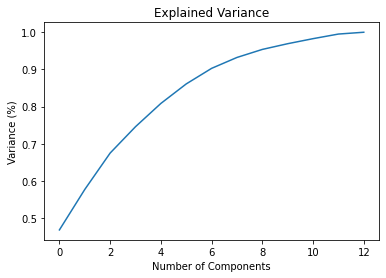

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
principalComponents = pca.fit_transform(X_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

We usually take the nr of principal components that explain around 90-93% variance of data. In our case 8 components explain more than 90% of the data variance.

In [41]:
pca = PCA(n_components=9)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(379, 9)
(127, 9)


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def pca_multicolleniarity(X_train, X_test, n_components):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    pipeline = Pipeline([('scaler', scaler),
                         ('pca', pca)])
    
    new_X_train = pipeline.fit_transform(X_train)
    new_X_test = pipeline.transform(X_test)
    
    return new_X_train, new_X_test

In [43]:
# X_train, X_test = pca_multicolleniarity(X_train, X_test, 8)
# print(X_train.shape)
# print(X_test.shape)

After dimensionality reduction we have also removed the multicolleniarity between the independent features.

In [44]:
# we have already scaled the data. No need to use Pipeline including StandardScaler

lr = Pipeline([('scaler', StandardScaler()),
               ('estimator', LinearRegression())])

print(f"CV Score : {np.mean(cross_val_score(lr, X_train, y_train, scoring='r2'))}")

lr.fit(X_train, y_train)
print(f"Test Score : {r2_score(y_test, lr.predict(X_test))}")

CV Score : 0.6978407297830962
Test Score : 0.5680239494146473


### 5.  L1 Regularization  with Linear Regression, LogisticRegression or Support Vector Machine

We can perform Regularization using 3 different ML Estimators. <br>

A) Regularization with Linear Regression we use Lasso or ElasticNet. <br>
B) Regularization with Logistic Regression we use LogisticRegression(penalty='l1'). <br>
C) Regularization with Support Vector Machine we use LinearSCV(penalty='l1'). <br>


penalty : possible values 'l1', 'l2', 'elasticnet'. Usually for feature selection 'l1' and elastic net are used. <br>
solver : the algorithm to use in the optimization : possible values : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’. Check sklearn documentation

Using regularization we penalize the cost function by adding the regularization term which means we will get small coefficients (very close to 0). This means that those features does not affect the target feature (they are already removed). Lasso is more prefered than Ridge since it can make the weights exactly zero (perform feature selection) and penalize the features that are not useful (reduce their weights) while Ridge will assign to those features a huger weight. 
In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated

**Note:**<br>
This approach despite removing highly correlated independent features it will also perform feature selection.

In [45]:
data = load_boston()
df = pd.DataFrame(data.data, columns = data.feature_names)
df["MEDV"] = data.target
X = df.drop("MEDV",axis=1)   #Feature Matrix
y = df["MEDV"] 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel


def feature_selection_SelectFromModel(X_train, y_train, X_test, model, threshold=None):
    try:
        print('Entered function feature_selection_SelectFromModel.')
        
        nr_total_features = X_train.shape[1]

        model.fit(X_train, y_train)

        selector = SelectFromModel(model, prefit=True, threshold=threshold)
        indices_selected_cols = list(selector.get_support(indices=True))
        cols_selected = X_train.columns[indices_selected_cols]
        nr_features_selected = len(cols_selected)
        print(cols_selected)

        new_X_train = pd.DataFrame(data=selector.transform(X_train), columns=cols_selected)
        new_X_test = pd.DataFrame(data=selector.transform(X_test), columns=cols_selected)
        
        # If estimator measures the feature importance feature_importance use this code to plot the feature importances 
        # if it uses other measurement like coef_ or others using this code will not work
        
        #ranked_features=pd.Series(model.feature_importances_,index=X_train.columns)
        #ranked_features.nlargest(10).plot(kind='barh')
        #plt.savefig('Feature_Ranking.jpg')
        #plt.show()
        
        print('Function feature_selection_SelectFromModel Completed Successfully. Exited this function')
        return new_X_train, new_X_test
    
    except Exception as e:
        print('Error occured in function feature_selection_SelectFromModel. Error Message : ' + str(e))

In [47]:
# since we have Regression Problem we can use Lasso or ElasticNet
from sklearn.linear_model import Lasso, ElasticNet

print(X_train.shape)
estimator=Lasso(alpha=1.2)
new_X_train, new_X_test = feature_selection_SelectFromModel(X_train, y_train, X_test, estimator, threshold=0.01)
print(new_X_train.shape)

(379, 13)
Entered function feature_selection_SelectFromModel.
Index(['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')
Function feature_selection_SelectFromModel Completed Successfully. Exited this function
(379, 9)


In [48]:
lr = Pipeline([('scaler', StandardScaler()),
              ('estimator' , LinearRegression())])

lr.fit(new_X_train, y_train)
r2_score(y_test, lr.predict(new_X_test))

0.5944411120033037

#### Let try with Big Dataset
https://www.kaggle.com/c/santander-customer-satisfaction/data?select=train.csv

In [49]:
df=pd.read_csv('santander.csv',nrows=10000)
X=df.drop(labels=['TARGET'], axis=1)
y=df['TARGET']
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['TARGET'], axis=1),
    df['TARGET'],
    test_size=0.3,
    random_state=0)

FileNotFoundError: [Errno 2] No such file or directory: 'santander.csv'

In [ ]:
import seaborn as sns
#Using Pearson Correlation
corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

In [ ]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

In [ ]:
corr_features

In [ ]:
X_train.drop(corr_features,axis=1)